# Modèle de Classification detection d'anomalies

https://blog.floydhub.com/introduction-to-anomaly-detection-in-python/

## 1. Librairies

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Dataset

In [225]:
# nom de fichier et chemin relatif
filename = 'metrics_events_split_df.csv'
path = '../data/metrics/'
# création d'un dataframe à partir du csv de données
df = pd.read_csv(path+filename, index_col=0)
df.head(2)

,source,message,timestamp,criticality,identification,id,varnishLevelsTargetvolume,varnishLevelsTotalvolume,VarnishPrinter_3DVarnishCounter,iFoil_TotalPagesCounter
0,PLC,JV-Ti non prêt : impression impossible,2022-04-15 05:55:23.462000+00:00,INFO,391,4169749,36192.322612,100000,1792992,22881
1,iFoil,JV-Ti non prêt : impression impossible,2022-04-15 06:06:56.278000+00:00,INFO,391,4170152,36192.322612,100000,1792992,22881


In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81361 entries, 0 to 81360
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   source                           81361 non-null  object 
 1   message                          81344 non-null  object 
 2   timestamp                        81361 non-null  object 
 3   criticality                      81361 non-null  object 
 4   identification                   81361 non-null  int64  
 5   id                               81361 non-null  int64  
 6   varnishLevelsTargetvolume        81361 non-null  float64
 7   varnishLevelsTotalvolume         81361 non-null  int64  
 8   VarnishPrinter_3DVarnishCounter  81361 non-null  int64  
 9   iFoil_TotalPagesCounter          81361 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 6.8+ MB


## 3. Fonctions

In [227]:
# création d'un dictionnaire des criticité avec leur niveau
def ordinal_features_encoding(serie):
    categories_mapper = {}
    index = 1
    for cat in list(serie) :
        categories_mapper[cat] = index
        index += 1
    return categories_mapper

## 4. Selection

In [228]:
# on recherche la source la plus représentée
df.groupby('source')['id'].nunique().sort_values(ascending=False)

source
PLC        56499
iFoil       9582
Kernel      1282
ICB n°2       89
ICB n°5       80
RCB n°1       37
RCB n°2       33
RCB n°3       31
ICB n°1       18
ICB n°8       17
ICB n°4       16
ICB n°6        9
ICB n°7        2
Pilot          2
Name: id, dtype: int64

### a. PLC

#### i. Dataframe

In [229]:
# création d'un dataframe de la source PLC
plc_df = df[df.source == 'PLC']
print(plc_df.info())
# trie des valeurs par timestamp
plc_df = plc_df.sort_values(by='timestamp') 
# suppression des colonnes inutiles
plc_df = plc_df.drop(['source', 'message'], axis=1)
# conversion des types datetim et numerique
plc_df["timestamp"] = pd.to_datetime(plc_df["timestamp"], utc=True)
plc_df["varnishLevelsTargetvolume"] = np.round(plc_df["varnishLevelsTargetvolume"] , decimals=2)
# encodage de la colonne criticality
plc_df["criticality"] = plc_df["criticality"].replace(ordinal_features_encoding(plc_df.criticality.unique()))
# réindexation
plc_df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 66877 entries, 0 to 81360
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   source                           66877 non-null  object 
 1   message                          66863 non-null  object 
 2   timestamp                        66877 non-null  object 
 3   criticality                      66877 non-null  object 
 4   identification                   66877 non-null  int64  
 5   id                               66877 non-null  int64  
 6   varnishLevelsTargetvolume        66877 non-null  float64
 7   varnishLevelsTotalvolume         66877 non-null  int64  
 8   VarnishPrinter_3DVarnishCounter  66877 non-null  int64  
 9   iFoil_TotalPagesCounter          66877 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 5.6+ MB
None


In [230]:
print(plc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66877 entries, 0 to 66876
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   timestamp                        66877 non-null  datetime64[ns, UTC]
 1   criticality                      66877 non-null  int64              
 2   identification                   66877 non-null  int64              
 3   id                               66877 non-null  int64              
 4   varnishLevelsTargetvolume        66877 non-null  float64            
 5   varnishLevelsTotalvolume         66877 non-null  int64              
 6   VarnishPrinter_3DVarnishCounter  66877 non-null  int64              
 7   iFoil_TotalPagesCounter          66877 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(6)
memory usage: 4.1 MB
None


In [231]:
# c_df = df[["criticality", 'timestamp']].copy()
# c_df.timestamp = pd.to_datetime(c_df.timestamp, errors='ignore', utc=True, format="%f")
# c_df.index = df["timestamp"] 
# del c_df["timestamp"]
# c_df.info()
# c_df["criticality"].plot(figsize=(15, 6))
# plt.show()


In [232]:
# Generate a Boxplot
# df1['criticality'].plot(kind='box')
# plt.show()

In [233]:
# # Generate a Histogram plot
# plc_df['criticality'].plot(kind='hist')
# plt.show()

#### ii. Visualisation

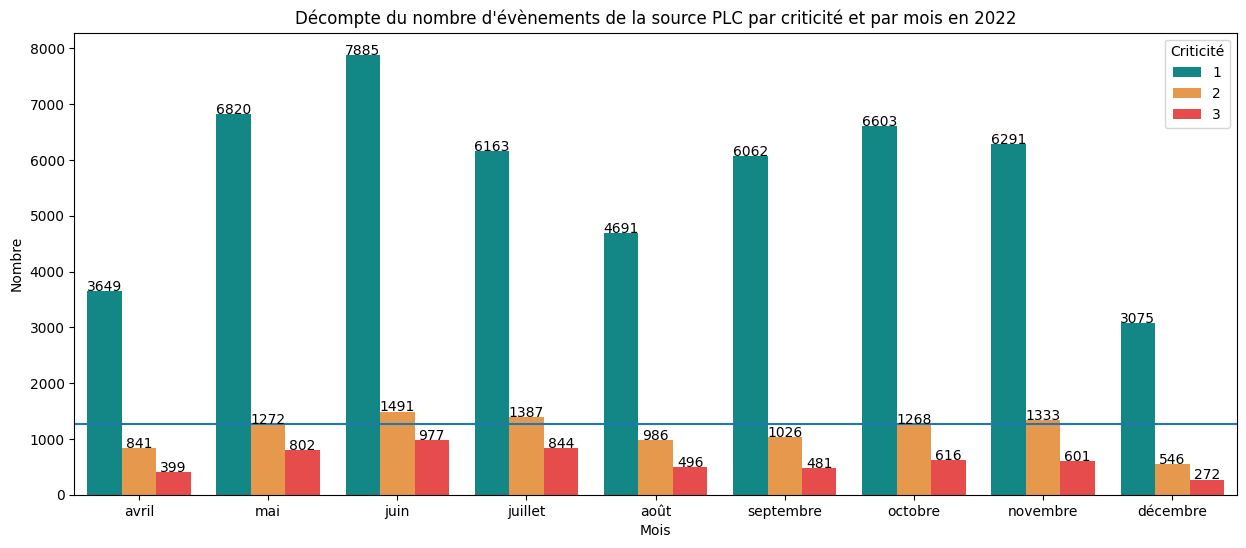

In [234]:
import seaborn as sns
from babel.dates import format_date

# On filtrer pour n'inclure que les lignes avec 'ERR' ou 'WARNING'.
df_filtered = plc_df.copy()

# Indexation des timestamp
df_filtered.index = df_filtered.timestamp

# Rééchantillonnage par mois et comptage du nombre d'events_id pour chaque mois.
df_monthly_counts = df_filtered.resample('M')['criticality'].value_counts().rename('count').reset_index()

# On convertie les dates en Français
df_monthly_counts['month'] = df_monthly_counts['timestamp'].apply(lambda x: format_date(x, 'MMMM', locale='fr_FR'))

# On affiche avec seaborn
plt.figure(figsize=(15, 6))
splot = sns.barplot(data=df_monthly_counts,
                    x='month', 
                    y='count', 
                    palette=["#009999", "#FF9933", "#FF3333"], 
                    hue='criticality')
# Ajoute une étiquette de valeur à chaque colonne
for g in splot.patches:
    splot.annotate(text=format(g.get_height(), '.0f'),
                   xy=(g.get_x() + g.get_width() / 2., g.get_height()),
                   ha='center', 
                   va='center',
                   xytext=(0, 3),
                   textcoords='offset points')
#Drawing a horizontal line
splot.axhline(df_monthly_counts['count'].median())

plt.title("Décompte du nombre d'évènements de la source PLC par criticité et par mois en 2022")
plt.xlabel('Mois')
plt.ylabel('Nombre')
plt.legend(title='Criticité')

plt.show()

### b. Ifoil

#### i. Dataframe

In [235]:
# création d'un dataframe de la source iFoil
ifoil_df = df[df.source == 'iFoil']
print(ifoil_df.info())
# trie des valeurs par timestamp
ifoil_df = ifoil_df.sort_values(by='timestamp') 
# suppression de colonnes 
ifoil_df = ifoil_df.drop(['identification','source', 'message', 'varnishLevelsTargetvolume','varnishLevelsTotalvolume','VarnishPrinter_3DVarnishCounter'], axis=1)
# conversion des types datetim et numerique
ifoil_df["timestamp"] = pd.to_datetime(ifoil_df["timestamp"], utc=True)
# encodage de la colonne criticality
ifoil_df["criticality"] = ifoil_df["criticality"].replace(ordinal_features_encoding(ifoil_df.criticality.unique()))
# réindexation
ifoil_df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12805 entries, 1 to 81320
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   source                           12805 non-null  object 
 1   message                          12802 non-null  object 
 2   timestamp                        12805 non-null  object 
 3   criticality                      12805 non-null  object 
 4   identification                   12805 non-null  int64  
 5   id                               12805 non-null  int64  
 6   varnishLevelsTargetvolume        12805 non-null  float64
 7   varnishLevelsTotalvolume         12805 non-null  int64  
 8   VarnishPrinter_3DVarnishCounter  12805 non-null  int64  
 9   iFoil_TotalPagesCounter          12805 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 1.1+ MB
None


In [236]:
ifoil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12805 entries, 0 to 12804
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   timestamp                12805 non-null  datetime64[ns, UTC]
 1   criticality              12805 non-null  int64              
 2   id                       12805 non-null  int64              
 3   iFoil_TotalPagesCounter  12805 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3)
memory usage: 400.3 KB


#### ii. Visualisation

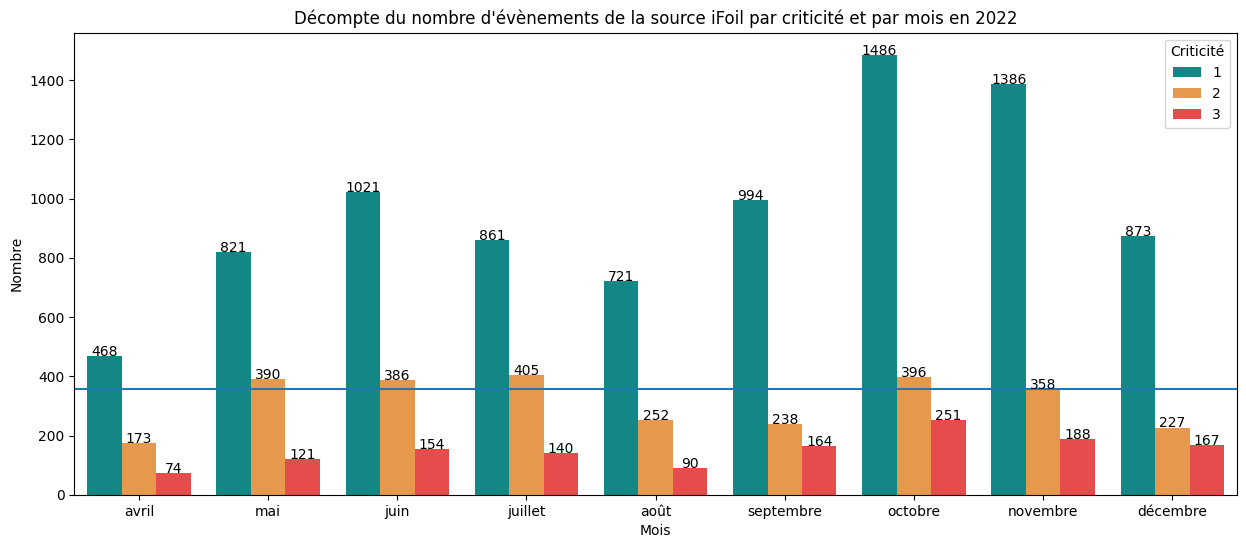

In [237]:
# On filtrer pour n'inclure que les lignes avec 'ERR' ou 'WARNING'.
df_filtered2 = ifoil_df.copy()

# Indexation des timestamp
df_filtered2.index = df_filtered2.timestamp

# Rééchantillonnage par mois et comptage du nombre d'events_id pour chaque mois.
df_monthly_counts2 = df_filtered2.resample('M')['criticality'].value_counts().rename('count').reset_index()

# On convertie les dates en Français
df_monthly_counts2['month'] = df_monthly_counts2['timestamp'].apply(lambda x: format_date(x, 'MMMM', locale='fr_FR'))

# On affiche avec seaborn
plt.figure(figsize=(15, 6))
splot2 = sns.barplot(data=df_monthly_counts2,
                    x='month', 
                    y='count', 
                    palette=["#009999", "#FF9933", "#FF3333"], 
                    hue='criticality')
# Ajoute une étiquette de valeur à chaque colonne
for g in splot2.patches:
    splot2.annotate(text=format(g.get_height(), '.0f'),
                   xy=(g.get_x() + g.get_width() / 2., g.get_height()),
                   ha='center', 
                   va='center',
                   xytext=(0, 3),
                   textcoords='offset points')
#Drawing a horizontal line
splot2.axhline(df_monthly_counts2['count'].median())

plt.title("Décompte du nombre d'évènements de la source iFoil par criticité et par mois en 2022")
plt.xlabel('Mois')
plt.ylabel('Nombre')
plt.legend(title='Criticité')

plt.show()

In [238]:
ifoil_df.head(2)

,timestamp,criticality,id,iFoil_TotalPagesCounter
0,2022-04-15 06:06:56.278000+00:00,1,4170152,22881
1,2022-04-15 06:40:40.321000+00:00,1,4171311,22883


## 4. Création du dataset iFoil : metrics + jobs

### a. Import datasets

In [255]:
# Load time series data
time_series_df = ifoil_df.copy()
time_series_df = time_series_df.drop(['id'], axis=1)
print(time_series_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12805 entries, 0 to 12804
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   timestamp                12805 non-null  datetime64[ns, UTC]
 1   criticality              12805 non-null  int64              
 2   iFoil_TotalPagesCounter  12805 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2)
memory usage: 300.2 KB
None


#### jobs ifoil column

In [256]:
# création d'un dataframe à partir du csv de données
jobs_ifoil_df = pd.read_csv('../data/jobs/jobs_uses_ifoil_df.csv', index_col=0)
jobs_ifoil_df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
jobs_ifoil_df.head(2)

,id,total_copies,started_at,ended_at,speed,operator,operator_level,paperHeight,paperWidth,jobId,total_copies_requested
0,6191,0,2021-06-29 14:14:56.792000+00:00,2021-06-29 14:14:58.759000+00:00,313,1,1,520,740,1624976096,1
1,6192,2,2021-06-29 14:15:16.235000+00:00,2021-06-29 14:20:17.203000+00:00,313,1,1,520,740,1624976116,25


In [257]:
jobs_ifoil_df.jobId.duplicated().any()

False

#### job_events ifoil column

In [258]:
job_events_ifoil_df = pd.read_csv('../data/jobs/idf.csv', index_col=0)
job_events_ifoil_df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
# conversion des types datetim et numerique
job_events_ifoil_df["timestamp"] = pd.to_datetime(job_events_ifoil_df["timestamp"], utc=True)
print(job_events_ifoil_df.info())
job_events_ifoil_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16295 entries, 0 to 16294
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   timestamp           16295 non-null  datetime64[ns, UTC]
 1   totalCopies         16295 non-null  int64              
 2   jobId               16295 non-null  int64              
 3   speed               16295 non-null  float64            
 4   enabled             16295 non-null  bool               
 5   optifoil            16295 non-null  bool               
 6   heater1Enabled      16295 non-null  bool               
 7   speedTensionIn      16295 non-null  float64            
 8   heater1Temperature  16295 non-null  int64              
dtypes: bool(3), datetime64[ns, UTC](1), float64(2), int64(3)
memory usage: 811.7 KB
None


,timestamp,totalCopies,jobId,speed,enabled,optifoil,heater1Enabled,speedTensionIn,heater1Temperature
0,2021-06-18 09:22:46.866189200+00:00,3,1624008166,31.799999,False,True,False,-0.2,115
1,2021-06-18 10:08:13.716973900+00:00,100,1624010893,26.200001,False,True,False,-0.2,115


In [259]:
job_events_ifoil_df.jobId.duplicated().any()

False

### b. Fusion dataframes

#### fusion jobs + job_events ifoil columns

In [260]:
jobs_batch_df = job_events_ifoil_df.merge(right=jobs_ifoil_df, on='jobId', how='outer', suffixes=['_events', '_jobs']).sort_values(by='timestamp')

In [261]:
jobs_batch_df

,timestamp,totalCopies,jobId,speed_events,enabled,optifoil,heater1Enabled,speedTensionIn,heater1Temperature,id,total_copies,started_at,ended_at,speed_jobs,operator,operator_level,paperHeight,paperWidth,total_copies_requested
0,2021-06-18 09:22:46.866189200+00:00,3,1624008166,31.799999,False,True,False,-0.2,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-18 10:08:13.716973900+00:00,100,1624010893,26.200001,False,True,False,-0.2,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-06-18 10:11:52.165952600+00:00,100,1624011111,26.200001,False,True,False,-0.2,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-06-18 10:30:23.049649100+00:00,50,1624012222,42.000000,False,True,False,-0.2,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-06-18 12:35:11.864117300+00:00,1,1624019711,42.000000,False,True,False,-0.2,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16290,2022-12-12 08:18:59.581900+00:00,3,1670833139,26.200001,False,True,False,-0.2,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16291,2022-12-12 08:22:04.409915600+00:00,3,1670833324,26.200001,False,True,False,-0.2,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16292,2022-12-12 08:24:46.438612200+00:00,80,1670833486,26.200001,False,True,False,-0.2,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16293,2022-12-12 08:28:34.659403500+00:00,80,1670833714,26.200001,False,True,False,-0.2,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### fusion ifoil_df + metrics

In [262]:
df_1 = time_series_df.copy()
df_1["timestamp"] = pd.to_datetime(df_1["timestamp"]).astype('int64')

df_2 = jobs_ifoil_df.copy()
df_2["started_at"] = pd.to_datetime(df_2["started_at"]).astype('int64')
df_2["ended_at"] = pd.to_datetime(df_2["ended_at"]).astype('int64')

compare = (df_2[["started_at"]].values < df_1.timestamp.values) & (df_2[["ended_at"]].values > df_1.timestamp.values)

## get cell numbers which is in range 0 to matrix size which meets the condition
ind = np.arange(len(df_1)*len(df_2))[compare.ravel()]

## calculate row and column index from cell number
merge_df = pd.concat([df_2.iloc[ind//len(df_1)].reset_index(drop=True), df_1.iloc[ind%len(df_1)].reset_index(drop=True)], axis=1, sort=False)

In [263]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   id                       3426 non-null   int64
 1   total_copies             3426 non-null   int64
 2   started_at               3426 non-null   int64
 3   ended_at                 3426 non-null   int64
 4   speed                    3426 non-null   int64
 5   operator                 3426 non-null   int64
 6   operator_level           3426 non-null   int64
 7   paperHeight              3426 non-null   int64
 8   paperWidth               3426 non-null   int64
 9   jobId                    3426 non-null   int64
 10  total_copies_requested   3426 non-null   int64
 11  timestamp                3426 non-null   int64
 12  criticality              3426 non-null   int64
 13  iFoil_TotalPagesCounter  3426 non-null   int64
dtypes: int64(14)
memory usage: 374.8 KB


In [266]:
merge_df = merge_df.drop(['id','timestamp','started_at', 'ended_at', 'jobId'], axis=1)

In [267]:
merge_df

,total_copies,speed,operator,operator_level,paperHeight,paperWidth,total_copies_requested,criticality,iFoil_TotalPagesCounter
0,2,313,1,1,450,320,2,1,35692
1,2,313,1,1,450,320,2,1,35692
2,2,418,1,1,450,320,2,1,35697
3,2,627,1,1,450,320,2,1,35698
4,55,627,1,1,450,320,120,1,35702
...,...,...,...,...,...,...,...,...,...
3421,41,313,3,1,450,320,41,1,53341
3422,50,313,3,1,450,320,50,1,53380
3423,50,313,3,1,450,320,50,1,53382
3424,50,313,3,1,450,320,50,1,53382


## Test

In [ ]:
## load sample data
df1 = pd.DataFrame([
    ('0', '2019-07-14 05:31:00', '0.020228', '0.026572', 10), 
    ('1', '2019-07-14 06:32:00', '0.057780', '0.175499', 12), 
    ('2', '2019-07-14 07:02:00', '0.076623', '0.875499', 15),
    ('3', '2019-07-14 07:12:00', '0.086623', '0.895499', 16),
    ('4', '2019-07-14 08:32:00', '0.096623', '0.035499', 20)
    ], 
                   columns=('id', 'timestamp', 'A', 'B', 'C'))
df2 = pd.DataFrame([
    ('10', '2019-07-14 05:30:00', '2019-07-14 06:30:00', 'E1'), 
    ('11', '2019-07-14 06:00:00', '2019-07-14 07:00:00', 'E2'), 
    ('12', '2019-07-14 06:30:01', '2019-07-14 07:30:00', 'E3'), 
    ('13', '2019-07-14 07:30:01', '2019-07-14 08:30:00', 'E4')
    ], 
                   columns=('id', 'start', 'end', 'event'))

df1["timestamp"] = pd.to_datetime(df1["timestamp"])
df2["start"] = pd.to_datetime(df2["start"])
df2["end"] = pd.to_datetime(df2["end"])

In [ ]:
df1.timestamp.values

array(['2019-07-14T05:31:00.000000000', '2019-07-14T06:32:00.000000000',
       '2019-07-14T07:02:00.000000000', '2019-07-14T07:12:00.000000000',
       '2019-07-14T08:32:00.000000000'], dtype='datetime64[ns]')

In [ ]:
df2[["start"]].values 

array([['2019-07-14T05:30:00.000000000'],
       ['2019-07-14T06:00:00.000000000'],
       ['2019-07-14T06:30:01.000000000'],
       ['2019-07-14T07:30:01.000000000']], dtype='datetime64[ns]')

In [ ]:
## df2[["start"]] is a column vector of size m and df1.timestamp.values is row 
## vector of size n then broad cast will result matrix of shape m,n which is 
## result of comparing each pair of m and n
compare = (df2[["start"]].values < df1.timestamp.values) & (df2[["end"]].values > df1.timestamp.values)

## get cell numbers which is in range 0 to matrix size which meets the condition
ind = np.arange(len(df1)*len(df2))[compare.ravel()]

## calculate row and column index from cell number
pd.concat([df2.iloc[ind//len(df1)].reset_index(drop=True), df1.iloc[ind%len(df1)].reset_index(drop=True)], axis=1, sort=False)

,id,start,end,event,id,timestamp,A,B,C
0,10,2019-07-14 05:30:00,2019-07-14 06:30:00,E1,0,2019-07-14 05:31:00,0.020228,0.026572,10
1,11,2019-07-14 06:00:00,2019-07-14 07:00:00,E2,1,2019-07-14 06:32:00,0.057780,0.175499,12
2,12,2019-07-14 06:30:01,2019-07-14 07:30:00,E3,1,2019-07-14 06:32:00,0.057780,0.175499,12
3,12,2019-07-14 06:30:01,2019-07-14 07:30:00,E3,2,2019-07-14 07:02:00,0.076623,0.875499,15
4,12,2019-07-14 06:30:01,2019-07-14 07:30:00,E3,3,2019-07-14 07:12:00,0.086623,0.895499,16
